In [134]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import matplotlib.pyplot 
import Bio
#Neighbour Join Tree
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import matplotlib.pyplot as plt
import Bio.Phylo as Phylo
import os
import Bio.Phylo as Phylo
import warnings

In [3]:
df_weekly_sum = pd.read_csv('dpgr_who_countries_1.csv')
print(df_weekly_sum)

       Variant                   Date                         Location  Freq
0        Alpha  2019-12-30/2020-01-05  Africa / South Africa / Gauteng     1
1        Alpha  2019-12-30/2020-01-05            Asia / India / Kerala     5
2        Alpha  2019-12-30/2020-01-05        Asia / India / Tamil Nadu     1
3        Alpha  2019-12-30/2020-01-05                          Austria     4
4        Alpha  2019-12-30/2020-01-05                  Europe / Cyprus    21
...        ...                    ...                              ...   ...
83732  Omicron  2022-05-30/2022-06-05                      South Korea     3
83733  Omicron  2022-05-30/2022-06-05                            Spain   177
83734  Omicron  2022-05-30/2022-06-05                           Sweden     6
83735  Omicron  2022-05-30/2022-06-05                      Switzerland    69
83736  Omicron  2022-05-30/2022-06-05                              USA  4135

[83737 rows x 4 columns]


In [4]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
# def create_distance_matrix(df,quarter_continent):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     distance_matrix = pd.DataFrame(index = clade_list)
#     distance_matrix[clade_list] = np.nan
#     #fill in distance matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 distance_matrix.loc[i,j] = 0
#             else:
#                 distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     return distance_matrix

#this distance matrix only selects clades thats within the clade list
def create_distance_matrix(df, quarter_continent, variant_choice_set):
    clade_list = set()
    for variant in df['Variant']:
        clades = variant.split(' vs ')
        clade_list.update(clades)
#         print(clade_list)

    
    clade_list = sorted(clade_list)
    clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
    distance_matrix.fillna(0, inplace=True)

    for i in clade_list:
        for j in clade_list:
            if i != j:
                variant_1 = f"{i} vs {j}"
                variant_2 = f"{j} vs {i}"
                slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
                slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
                slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
                distance_matrix.loc[i, j] = abs(slope)
                distance_matrix.loc[j, i] = abs(slope)

    return distance_matrix


# #function to generate difference matrix based on quarter, year, and continent
# def create_difference_matrix(df,quarter_continent):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     difference_matrix = pd.DataFrame(index = clade_list)
#     difference_matrix[clade_list] = np.nan
#     #fill in difference matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 difference_matrix.loc[i,j] = 0
#             else:
#                 difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     #if row_vs_col is a negative value, make it negative in difference matrix
#     for i,v in difference_matrix.iterrows():
#         for j in difference_matrix:
#             if i != j:
#                 if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
#                     difference_matrix.loc[i,j] *= -1
#     return difference_matrix

#Modifed the distance matrix , here the input is only the generated distance matrix
#function to generate difference matrix based on quarter, year, and continent
# def create_difference_matrix(distance_matrix):
# #     tmp = df['Variant'].str.split('vs', expand=True)
# #     clade_list = tmp[0].unique()
# #     difference_matrix = pd.DataFrame(index = clade_list)
# #     difference_matrix[clade_list] = np.nan
# #     #fill in difference matrix
# #     for i in clade_list:
# #         for j in clade_list:
# #             if i == j:
# #                 difference_matrix.loc[i,j] = 0
# #             else:
# #                 difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
# #                                                         quarter_continent].iloc[0] + 
# #                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                    quarter_continent].iloc[0])/2))
# #                 difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                         quarter_continent].iloc[0] + 
# #                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                    quarter_continent].iloc[0])/2))
#     #if row_vs_col is a negative value, make it negative in difference matrix
# #     for i,v in difference_matrix.iterrows():
# #         for j in difference_matrix:
# #             if i != j:
# #                 if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
# #                     difference_matrix.loc[i,j] *= -1
# #     return difference_matrix

#     difference_matrix = distance_matrix.copy()

#     # Iterate over the rows and columns of the difference_matrix
#     for i, row in difference_matrix.iterrows():
#         for j in difference_matrix.columns:
#             if i != j:
#                 # Check if the row_vs_col value is negative
#                 if distance_matrix.loc[i, j] < 0:
#                     # Set values above the main diagonal to the negative value
#                     difference_matrix.loc[i, j] = -abs(difference_matrix.loc[i, j])
#                     print(difference_matrix)
#                 else:
#                     # Set values below the main diagonal to the positive value
#                     difference_matrix.loc[i, j] = abs(difference_matrix.loc[i, j])
                    
#         return difference_matrix

def create_difference_matrix(distance_matrix):
    difference_matrix = distance_matrix.copy()

    # Iterate over the rows and columns of the difference_matrix
    for i, row in difference_matrix.iterrows():
        for j in difference_matrix.columns:
            if i != j:
                # Check if the row_vs_col value is negative
                if distance_matrix.loc[i, j] < 0:
                    # Set values above the main diagonal to the negative value
                    difference_matrix.loc[i, j] = -abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = abs(difference_matrix.loc[i, j])
                else:
                    # Set values below the main diagonal to the positive value
                    difference_matrix.loc[i, j] = abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = -abs(difference_matrix.loc[i, j])

    return difference_matrix


#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
#     print(f"dataframe after time window:\n {dataframe.head()}")
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

### *Use the automation mine function to create the distance matrix in variant choice set for specific time window*

In [5]:
# This function finds the distance matrix among all the clades 

def automation_mine(country, dataset, start, end, variant_choice_set):
    
    df_weekly = dataset[dataset['Location'] == country]
    
#     # Set the option to display all rows
#     pd.set_option('display.max_rows', None)
#     print(df_weekly)
    
#     print(df_weekly.head())
    #print unique variants available in the target location
    print(f"Vaiants available at {country} : {df_weekly['Variant'].unique()}")
    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
    tmp.columns = ['0','1','2','3']

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
#     print(f"df_weekly :\n {df_weekly.head}")
#     print(f"df_weekly : \n {df_weekly.columns}")
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
    # df_sum.to_csv(country+"df_sum"+r'.csv')
#     print(f"df_sum :\n {df_sum}")
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(f" df_ : \n{df_}")
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
#     print(f"df_ :\n {df_}")
#     print(f"df_ :\n {df_.columns}")
    

    #Make the combinations of the variant choice set
    combinations = []

    # Append 'Omicron vs Delta'
    combination1 = ' vs '.join(variant_choice_set)
    combinations.append(combination1)

    # Append 'Delta vs Omicron'
    combination2 = ' vs '.join(sorted(list(variant_choice_set), reverse=True))
    combinations.append(combination2)
    

    #calculate slopes, have to disregard nans
    df_slopes = pd.DataFrame()
    cols = df_.columns.to_list()
#     print(f"df_ columns : {cols}")
    df_slopes['Variant'] = cols[3:]
#     print(f"df_slopes:\n {df_slopes}")
    slopes = []
    for i,v in enumerate(df_.iloc[:,3:]):
#         tmp = df_[~df_.iloc[:,i+3].isnull()] ##issue (it chooses columns using the index)
        tmp = df_[df_.loc[:, df_.columns.isin(combinations)].notnull().any(axis=1)] #it chooses the columns that are given in the variant_choice set
        tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
#         print(f"tmp :\n {tmp}")
        slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
#         slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp[v])) 
        #print(len(slopes))
#         print(df_slopes)
#     print(f"tmp :\n {tmp}")
#     print(f"Slopes: {slopes}")
    df_slopes['Slope'] = slopes
#     print(df_slopes)
    df_slopes = pd.DataFrame(df_slopes)   #changed
    
#     dist_mat = create_distance_matrix(df_slopes,'Slope')
#     # dist_mat.to_csv(country+"_dist_mat_WHO"+r'.csv')
#     print(f"distance matrix :\n {dist_mat}")

#     #define the file path
#     file_path = f'/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/{country + "_" + start + "_" + end + "_dist_mat_who_labels"}.csv'

    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
#     dist_mat.to_csv(file_path, index=True)
    print(f"Diatance matrix: \n {dist_mat}")
    
    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
    file_name = f"{country}_{start}_{end}_dist_mat.csv"
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, file_name)
    dist_mat.to_csv(file_path, index=True)
    if os.path.isfile(file_path):
        print(f"Distance matrix saved at: {file_path}")
    else:
        print("Error: Failed to save the distance matrix.")


#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)
    
#     dif_mat = create_difference_matrix(df_slopes,'Slope')
#     # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
#     # print(f"difference matrix :\n {dif_mat}")

#     #Plot distance matrix as clustermap
#     sns.set(rc = {'figure.figsize':(10, 20)}, font_scale = 1.8)

#     #create distance array from distance matrix
#     distance_array = ssd.squareform(dist_mat) 

#     #create linkage object
#     distance_linkage = hierarchy.linkage(distance_array)
#     print(distance_array.shape)
#     print(dist_mat.shape)

#     #display clustermap
#     g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
#                         cmap = 'coolwarm',vmin=-.023,vmax=0.023, cbar_pos=(0.971, 0.087, .03, 0.7))                     
#     # g.fig.set_size_inches(10, 10)
#     # plt.savefig(country+"_clustermap_WHO"+'.jpg', dpi = 300, bbox_inches='tight')
#     return g

### *Combine the distance matrices and plot the heatmap for getting the combined distance matrix for all the variants*

In [271]:
def heatmaps_from_combined_dist_map(clade_list, df1, df2, df3, location): #pass dataframe in a sorted order
    # create an empty dataframe
    # clade_list = sorted(clade_list)
    # print(clade_list)

    # #this code snippet orders the clade list ccording to this order : order = ['Alpha', 'Beta', 'Delta', 'Omicron']
    # #which helps to create a distance matrix of our desired order 
    order = ['Alpha', 'Beta', 'Delta', 'Omicron']
    clade_list = sorted(clade_list, key=lambda x: order.index(x))
    
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    distance_matrix.fillna(0, inplace=True)
    
    # assign values to the empty dataframe
    distance_matrix.iloc[0:2, 0:2] = pd.DataFrame(df1)
    distance_matrix.iloc[1:3, 1:3] = pd.DataFrame(df2)
    distance_matrix.iloc[2:4, 2:4] = pd.DataFrame(df3)
    
    distance_matrix.iloc[0,2] = distance_matrix.iloc[0,1] + distance_matrix.iloc[1,2]
    distance_matrix.iloc[0,3] = distance_matrix.iloc[0,2] + distance_matrix.iloc[3,2]
    distance_matrix.iloc[1,3] = distance_matrix.iloc[1,2] + distance_matrix.iloc[2,3]
    distance_matrix.iloc[2,0] = distance_matrix.iloc[0,2] 
    distance_matrix.iloc[3,0] = distance_matrix.iloc[0,3] 
    distance_matrix.iloc[3,1] = distance_matrix.iloc[1,3] 
    
    # Set the index of the dataframe to the first column
    distance_matrix.set_index(distance_matrix.columns, inplace=True)
    print(f"Distance Matrix :\n {distance_matrix}")
    
    #export the combined distance matrix
    #export the distance matrix
    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_continent_combined_distance_matrix_for_who_labels.csv")
    print(f"Combined distance matrix saved at : {filename}")
    distance_matrix.to_csv(filename, index=False)

    
    dif_mat = create_difference_matrix(distance_matrix)
    # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
    # filename1 = os.path.join(directory, location + "_continent_combined_diference_matrix_for_who_labels.csv")
    # print(f"Combined difference matrix saved at : {filename1}")
    # dif_mat.to_csv(filename1, index=False)
    
    print(f"Difference matrix :\n {dif_mat}")
    
    #Plot distance matrix as clustermap
    sns.set(rc={'figure.figsize': (2, 2)}, font_scale=1.1)  # Adjust the figsize as per your preference

    #create distance array from distance matrix
    distance_array = ssd.squareform(distance_matrix) 

    #create linkage object
    distance_linkage = hierarchy.linkage(distance_array)
    #print(distance_array.shape)
    #print(dist_mat.shape)
    
    # # Display clustermap (no annotation)
    # g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
    #                cmap='coolwarm', vmin=-.023, vmax=0.023, cbar_pos=(0.971, 0.274, .05, 0.54 ),figsize=(5, 5))
 

    # Display clustermap with annotations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
                           cmap='coolwarm', vmin=-0.023, vmax=0.023, cbar_pos=(0.969, 0.147, 0.04, 0.7),
                           annot=True, fmt='.3f', annot_kws={"size": 7}, figsize=(4.6, 4.6), dendrogram_ratio=0.102)
    
        # Adjust colorbar label size
        cax = g.cax
        cax.set_yticklabels(cax.get_yticklabels(), fontsize=7)


#***************************************************************************************************************************************
    #Put the labels compared in each cell as text
    # Get the x-axis and y-axis labels from the clustermap plot
    x_labels = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
    y_labels = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
    # Add annotated texts in the cells
    for i in range(dif_mat.shape[0]):
        for j in range(dif_mat.shape[1]):
            text = f"{x_labels[i]} Vs. {y_labels[j]}"
            # value = f"{dif_mat.iloc[i, j]:.3f}"
            text_x = g.ax_heatmap.get_xticks()[j]
            text_y = g.ax_heatmap.get_yticks()[i]
            g.ax_heatmap.text(text_x, text_y + 0.2, text, ha='center', va='center', fontsize=5.5, color='black')
            
#***************************************************************************************************************************************
    g.fig.suptitle(f'Clustermap of Variant of Concerns(WHO labels) \nLocation: {location}', fontsize = 8.5, y = 1.05)

    #Save the figures in the specified directory
    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/combined_heatmaps_countries_WHO labels/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_who_label_combined_heatmaps_countries.png")
    g.savefig(filename, dpi=300, bbox_inches="tight")
    return g

#***************************************************************************************************************************************
    
    '''
        This portion of code plots the step plot of progressive fitness growth 
        of the variants
    '''

#     #export the combined distance matrix
#     #export the distance matrix
#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_combined_distance_matrix_for_who_labels.csv")
#     distance_matrix.to_csv(filename, index=False)
    
#     # Create a step plot
#     plt.figure(figsize=(3, 3))  # Set figure size to 3 by 3
#     plt.step(distance_matrix.index, distance_matrix.values[0], linewidth=1.5, color='red')

#     # Add labels and title
# #     plt.xlabel('Variants', fontsize=12)
#     plt.ylabel('Fitness Value', fontsize=12)
#     plt.title(f'Progressive fitness growth of Covid Variants\n Location: {location}', fontsize=12)

#     # Set the background color to white
#     plt.gca().set_facecolor('white')

#     # Add axis lines
#     plt.axhline(0, color='black', linewidth=0.5)
#     plt.axvline(-0.1, color='black', linewidth=0.5)
    
#     # Rotate x-axis labels
# #     plt.xticks(range(len(distance_matrix.index)), distance_matrix.index, rotation=90, fontsize=8)  # Adjust fontsize as needed
#     plt.xticks([])  # Remove x-axis tick labels
#     plt.yticks()

#     # Display the labels on the graph
#     categories = ['alpha', 'beta', 'delta', 'omicron']
#     x = range(len(categories))
#     values = distance_matrix.values[0][0:5]
#     print(values)
#     for i in range(len(categories)):
#         plt.text(x[i], values[i], f'{categories[i]}', ha='left', va='bottom')

# #     # Rotate x-axis labels
# #     plt.xticks(rotation=90)
# #     plt.yticks()

#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/figures_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_variant_step_plot.png")
#     plt.savefig(filename, dpi=300, bbox_inches="tight")
    
#     # Show the plot
#     plt.show()
    #*********************************************************************************************************************

## France 

In [272]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'France'])

In [273]:
# #automation function finds the diatance matrix
automation_mine('France', df_weekly_sum, start = '2021-01', end = '2021-02', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('France', df_weekly_sum, start = '2021-05', end = '2021-07', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('France', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at France : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-01', '2021-02']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.007791
Beta   0.007791  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/France_2021-01_2021-02_dist_mat.csv
Vaiants available at France : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06', '2021-07']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.027675
Delta  0.027675  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/France_2021-05_2021-07_dist_mat.csv
Vaiants available at France : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.069921
Omicron  0.069921  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/France_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.007791  0.035466  0.105387
Beta     0.007791  0.000000  0.027675  0.097596
Delta    0.035466  0.027675  0.000000  0.069921
Omicron  0.105387  0.097596  0.069921  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/France_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.007791 -0.035466 -0.105387
Beta     0.007791  0.000000 -0.027675 -0.097596
Delta    0.035466  0.027675  0.000000 -0.069921
Omicron  0.105387  0.097596  0.069921  0.000000


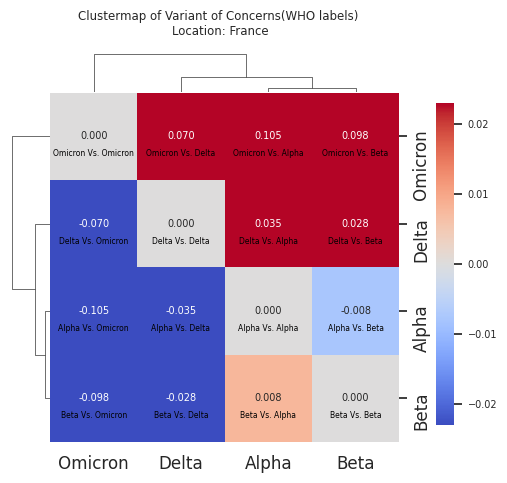

In [274]:
alpha_beta_fr = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/France_2021-01_2021-02_dist_mat.csv',
    index_col=0)
beta_delta_fr = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/France_2021-05_2021-07_dist_mat.csv',
    index_col= 0)
delta_omicron_fr = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/France_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_fr = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_fr,
                                                    beta_delta_fr,
                                                    delta_omicron_fr,
                                                    'France')
combined_distance_matrix_fr = pd.DataFrame(clustermap_obj_fr.data)



## Belgium

In [275]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Belgium'])

In [276]:
# #automation function finds the diatance matrix
automation_mine('Belgium', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Belgium', df_weekly_sum, start = '2021-04', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Belgium', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Belgium : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.014263
Beta   0.014263  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Belgium_2020-12_2021-01_dist_mat.csv
Vaiants available at Belgium : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-04', '2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.019079
Delta  0.019079  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Belgium_2021-04_2021-06_dist_mat.csv
Vaiants available at Belgium : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
            Delta  Omicron
Delta    0.00000  0.06377
Omicron  0.06377  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Belgium_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.014263  0.033342  0.097112
Beta     0.014263  0.000000  0.019079  0.082849
Delta    0.033342  0.019079  0.000000  0.063770
Omicron  0.097112  0.082849  0.063770  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Belgium_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.014263 -0.033342 -0.097112
Beta     0.014263  0.000000 -0.019079 -0.082849
Delta    0.033342  0.019079  0.000000 -0.063770
Omicron  0.097112  0.082849  0.063770  0.000000


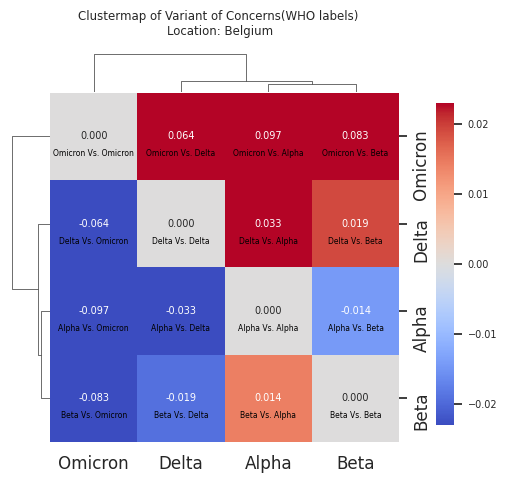

In [277]:
alpha_beta_bl = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Belgium_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_bl = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Belgium_2021-04_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_bl = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Belgium_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_bl = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_bl,
                                                    beta_delta_bl,
                                                    delta_omicron_bl,
                                                    'Belgium')
combined_distance_matrix_bl = pd.DataFrame(clustermap_obj_bl.data)



   ## Canada

In [278]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Canada'])

In [279]:
# #automation function finds the diatance matrix
automation_mine('Canada', df_weekly_sum, start = '2021-01', end = '2021-02', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Canada', df_weekly_sum, start = '2021-03', end = '2021-04', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Canada', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Canada : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-01', '2021-02']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.031635
Beta   0.031635  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Canada_2021-01_2021-02_dist_mat.csv
Vaiants available at Canada : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-03', '2021-04']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.042984
Delta  0.042984  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Canada_2021-03_2021-04_dist_mat.csv
Vaiants available at Canada : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.068758
Omicron  0.068758  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Canada_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.031635  0.074619  0.143377
Beta     0.031635  0.000000  0.042984  0.111742
Delta    0.074619  0.042984  0.000000  0.068758
Omicron  0.143377  0.111742  0.068758  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Canada_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.031635 -0.074619 -0.143377
Beta     0.031635  0.000000 -0.042984 -0.111742
Delta    0.074619  0.042984  0.000000 -0.068758
Omicron  0.143377  0.111742  0.068758  0.000000


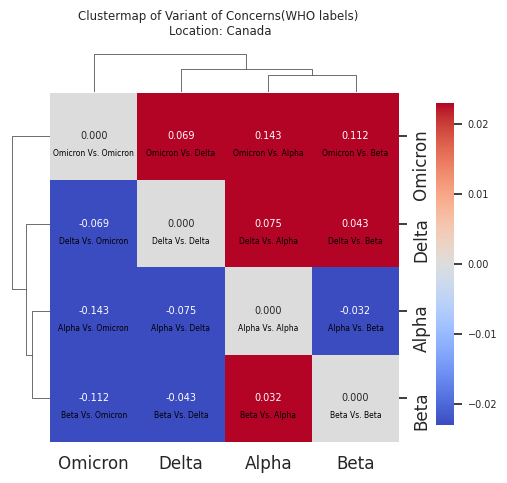

In [280]:
alpha_beta_ca = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Canada_2021-01_2021-02_dist_mat.csv',
    index_col=0)
beta_delta_ca = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Canada_2021-03_2021-04_dist_mat.csv',
    index_col= 0)
delta_omicron_ca = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Canada_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_ca = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_ca,
                                                    beta_delta_ca,
                                                    delta_omicron_ca,
                                                    'Canada')
combined_distance_matrix_ca = pd.DataFrame(clustermap_obj_ca.data)



## Denmark 

In [281]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Denmark'])

In [282]:
# #automation function finds the diatance matrix
automation_mine('Denmark', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Denmark', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Denmark', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Denmark : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.010137
Beta   0.010137  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Denmark_2020-12_2021-01_dist_mat.csv
Vaiants available at Denmark : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.030587
Delta  0.030587  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Denmark_2021-05_2021-06_dist_mat.csv
Vaiants available at Denmark : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.080128
Omicron  0.080128  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Denmark_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.010137  0.040724  0.120853
Beta     0.010137  0.000000  0.030587  0.110715
Delta    0.040724  0.030587  0.000000  0.080128
Omicron  0.120853  0.110715  0.080128  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Denmark_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.010137 -0.040724 -0.120853
Beta     0.010137  0.000000 -0.030587 -0.110715
Delta    0.040724  0.030587  0.000000 -0.080128
Omicron  0.120853  0.110715  0.080128  0.000000


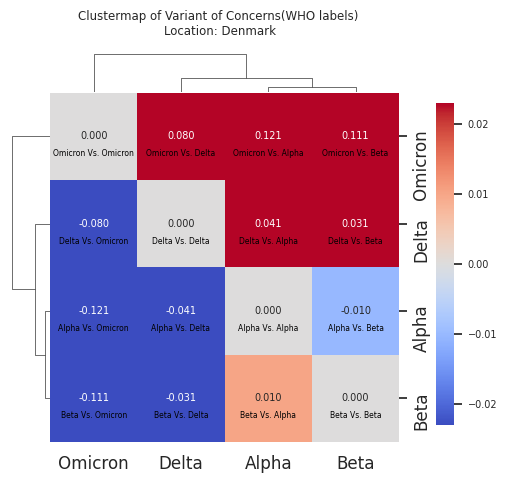

In [283]:
alpha_beta_den = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Denmark_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_den = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Denmark_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_den = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Denmark_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_den = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_den,
                                                    beta_delta_den,
                                                    delta_omicron_den,
                                                    'Denmark')
combined_distance_matrix_den= pd.DataFrame(clustermap_obj_den.data)



## Germany

In [284]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Germany'])

In [285]:
 # #automation function finds the diatance matrix
automation_mine('Germany', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Germany', df_weekly_sum, start = '2021-04', end = '2021-05', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Germany', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Germany : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.000393
Beta   0.000393  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Germany_2020-12_2021-01_dist_mat.csv
Vaiants available at Germany : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-04', '2021-05']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.023271
Delta  0.023271  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Germany_2021-04_2021-05_dist_mat.csv
Vaiants available at Germany : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.072157
Omicron  0.072157  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Germany_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.000393  0.023663  0.095820
Beta     0.000393  0.000000  0.023271  0.095427
Delta    0.023663  0.023271  0.000000  0.072157
Omicron  0.095820  0.095427  0.072157  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Germany_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.000393 -0.023663 -0.095820
Beta     0.000393  0.000000 -0.023271 -0.095427
Delta    0.023663  0.023271  0.000000 -0.072157
Omicron  0.095820  0.095427  0.072157  0.000000


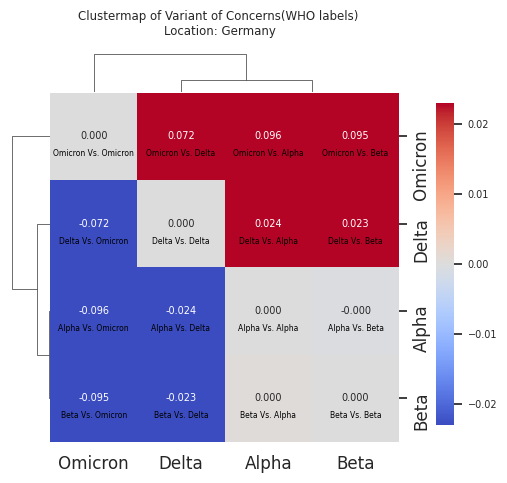

In [286]:
alpha_beta_gr= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Germany_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_gr = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Germany_2021-04_2021-05_dist_mat.csv',
    index_col= 0)
delta_omicron_gr = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Germany_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_gr = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_gr,
                                                    beta_delta_gr,
                                                    delta_omicron_gr,
                                                    'Germany')
combined_distance_matrix_gr= pd.DataFrame(clustermap_obj_gr.data)



## Ireland

In [287]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Ireland'])

In [288]:
 # #automation function finds the diatance matrix
automation_mine('Ireland', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Ireland', df_weekly_sum, start = '2021-04', end = '2021-05', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Ireland', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Ireland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.020674
Beta   0.020674  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Ireland_2020-12_2021-01_dist_mat.csv
Vaiants available at Ireland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-04', '2021-05']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.039489
Delta  0.039489  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Ireland_2021-04_2021-05_dist_mat.csv
Vaiants available at Ireland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
            Delta  Omicron
Delta    0.00000  0.07343
Omicron  0.07343  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Ireland_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.020674  0.060162  0.133592
Beta     0.020674  0.000000  0.039489  0.112918
Delta    0.060162  0.039489  0.000000  0.073430
Omicron  0.133592  0.112918  0.073430  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Ireland_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.020674 -0.060162 -0.133592
Beta     0.020674  0.000000 -0.039489 -0.112918
Delta    0.060162  0.039489  0.000000 -0.073430
Omicron  0.133592  0.112918  0.073430  0.000000


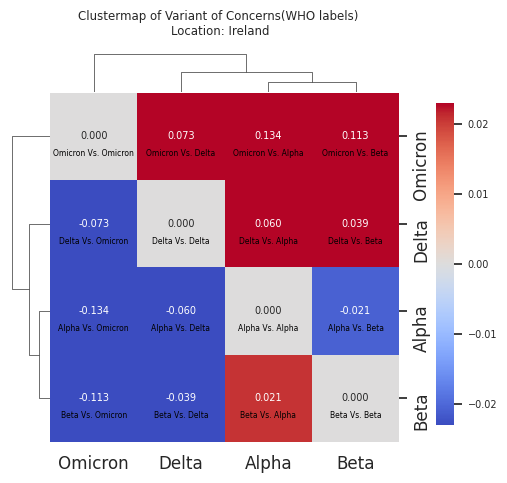

In [289]:
alpha_beta_ir= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Ireland_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_ir = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Ireland_2021-04_2021-05_dist_mat.csv',
    index_col= 0)
delta_omicron_ir = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Ireland_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_ir = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_ir,
                                                    beta_delta_ir,
                                                    delta_omicron_ir,
                                                    'Ireland')
combined_distance_matrix_ir= pd.DataFrame(clustermap_obj_ir.data)



## Israel

In [290]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Israel'])

In [291]:
 # #automation function finds the diatance matrix
automation_mine('Israel', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Israel', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Israel', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Israel : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.007646
Beta   0.007646  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Israel_2020-12_2021-01_dist_mat.csv
Vaiants available at Israel : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
           Beta    Delta
Beta   0.00000  0.00653
Delta  0.00653  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Israel_2021-05_2021-06_dist_mat.csv
Vaiants available at Israel : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.074902
Omicron  0.074902  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Israel_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.007646  0.014176  0.089077
Beta     0.007646  0.000000  0.006530  0.081432
Delta    0.014176  0.006530  0.000000  0.074902
Omicron  0.089077  0.081432  0.074902  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Israel_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.007646 -0.014176 -0.089077
Beta     0.007646  0.000000 -0.006530 -0.081432
Delta    0.014176  0.006530  0.000000 -0.074902
Omicron  0.089077  0.081432  0.074902  0.000000


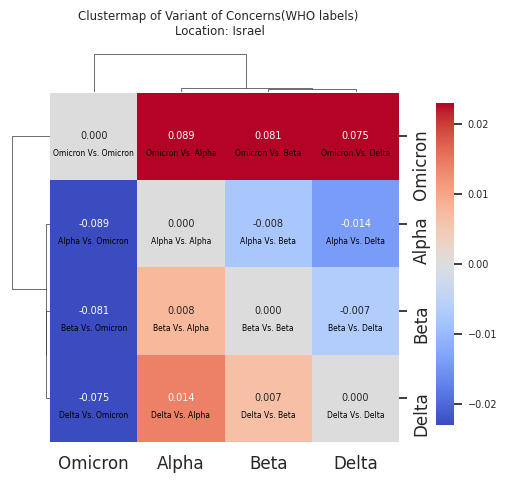

In [292]:
alpha_beta_is= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Israel_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_is = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Israel_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_is = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Israel_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_is = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_is,
                                                    beta_delta_is,
                                                    delta_omicron_is,
                                                    'Israel')
combined_distance_matrix_is= pd.DataFrame(clustermap_obj_is.data)



## Italy

In [293]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Italy'])

In [294]:
 # #automation function finds the diatance matrix
automation_mine('Italy', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Italy', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Italy', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Italy : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.009695
Beta   0.009695  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Italy_2020-12_2021-01_dist_mat.csv
Vaiants available at Italy : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.015336
Delta  0.015336  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Italy_2021-05_2021-06_dist_mat.csv
Vaiants available at Italy : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.074318
Omicron  0.074318  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Italy_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.009695  0.025031  0.099349
Beta     0.009695  0.000000  0.015336  0.089654
Delta    0.025031  0.015336  0.000000  0.074318
Omicron  0.099349  0.089654  0.074318  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Italy_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.009695 -0.025031 -0.099349
Beta     0.009695  0.000000 -0.015336 -0.089654
Delta    0.025031  0.015336  0.000000 -0.074318
Omicron  0.099349  0.089654  0.074318  0.000000


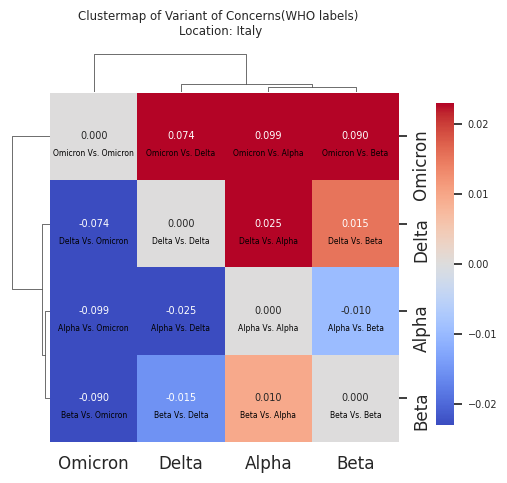

In [295]:
alpha_beta_it= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Italy_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_it = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Italy_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_it = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Italy_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_it = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_it,
                                                    beta_delta_it,
                                                    delta_omicron_it,
                                                    'Italy')
combined_distance_matrix_it = pd.DataFrame(clustermap_obj_it.data)



## Japan

In [296]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Japan'])

In [297]:
 # #automation function finds the diatance matrix
automation_mine('Japan', df_weekly_sum, start = '2021-02', end = '2021-03', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Japan', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Japan', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Japan : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-02', '2021-03']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.001599
Beta   0.001599  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Japan_2021-02_2021-03_dist_mat.csv
Vaiants available at Japan : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.007301
Delta  0.007301  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Japan_2021-05_2021-06_dist_mat.csv
Vaiants available at Japan : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.049711
Omicron  0.049711  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Japan_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.001599  0.008899  0.058610
Beta     0.001599  0.000000  0.007301  0.057012
Delta    0.008899  0.007301  0.000000  0.049711
Omicron  0.058610  0.057012  0.049711  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Japan_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.001599 -0.008899 -0.058610
Beta     0.001599  0.000000 -0.007301 -0.057012
Delta    0.008899  0.007301  0.000000 -0.049711
Omicron  0.058610  0.057012  0.049711  0.000000


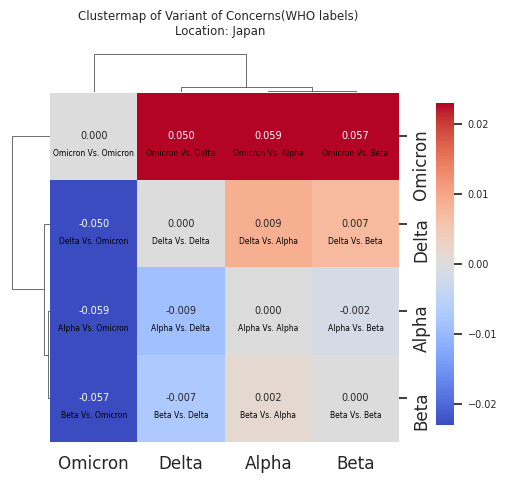

In [298]:
alpha_beta_jp= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Japan_2021-02_2021-03_dist_mat.csv',
    index_col=0)
beta_delta_jp = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Japan_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_jp = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Japan_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_jp = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_jp,
                                                    beta_delta_jp,
                                                    delta_omicron_jp,
                                                    'Japan')
combined_distance_matrix_jp = pd.DataFrame(clustermap_obj_jp.data)



## Netherlands

In [299]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Netherlands'])

In [300]:
 # #automation function finds the diatance matrix
automation_mine('Netherlands', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Netherlands', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Netherlands', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Netherlands : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.012271
Beta   0.012271  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Netherlands_2020-12_2021-01_dist_mat.csv
Vaiants available at Netherlands : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.039627
Delta  0.039627  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Netherlands_2021-05_2021-06_dist_mat.csv
Vaiants available at Netherlands : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.058998
Omicron  0.058998  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Netherlands_2021-11_2021

Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.012271  0.051898  0.110896
Beta     0.012271  0.000000  0.039627  0.098625
Delta    0.051898  0.039627  0.000000  0.058998
Omicron  0.110896  0.098625  0.058998  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Netherlands_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.012271 -0.051898 -0.110896
Beta     0.012271  0.000000 -0.039627 -0.098625
Delta    0.051898  0.039627  0.000000 -0.058998
Omicron  0.110896  0.098625  0.058998  0.000000


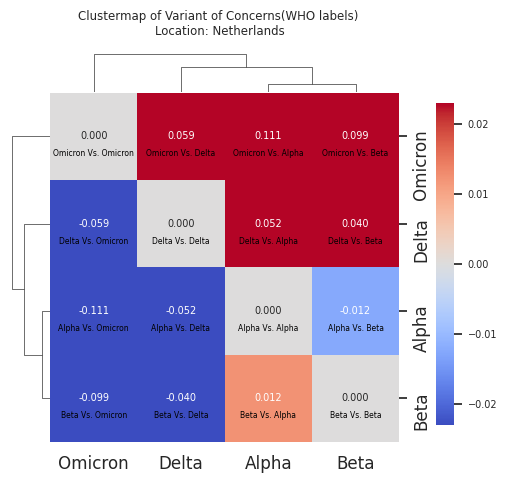

In [301]:
alpha_beta_ne= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Netherlands_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_ne = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Netherlands_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_ne = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Netherlands_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_ne = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_ne,
                                                    beta_delta_ne,
                                                    delta_omicron_ne,
                                                    'Netherlands')
combined_distance_matrix_ne = pd.DataFrame(clustermap_obj_ne.data)



## Poland

In [302]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Poland'])

In [303]:
 # #automation function finds the diatance matrix
automation_mine('Poland', df_weekly_sum, start = '2021-01', end = '2021-02', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Poland', df_weekly_sum, start = '2021-06', end = '2021-07', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Poland', df_weekly_sum, start = '2021-12', end = '2022-01', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Poland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-01', '2021-02']
Diatance matrix: 
          Alpha     Beta
Alpha  0.00000  0.02108
Beta   0.02108  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Poland_2021-01_2021-02_dist_mat.csv
Vaiants available at Poland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-06', '2021-07']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.061623
Delta  0.061623  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Poland_2021-06_2021-07_dist_mat.csv
Vaiants available at Poland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-12', '2022-01']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.052696
Omicron  0.052696  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Poland_2021-12_2022-01_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.021080  0.082703  0.135399
Beta     0.021080  0.000000  0.061623  0.114319
Delta    0.082703  0.061623  0.000000  0.052696
Omicron  0.135399  0.114319  0.052696  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Poland_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.021080 -0.082703 -0.135399
Beta     0.021080  0.000000 -0.061623 -0.114319
Delta    0.082703  0.061623  0.000000 -0.052696
Omicron  0.135399  0.114319  0.052696  0.000000


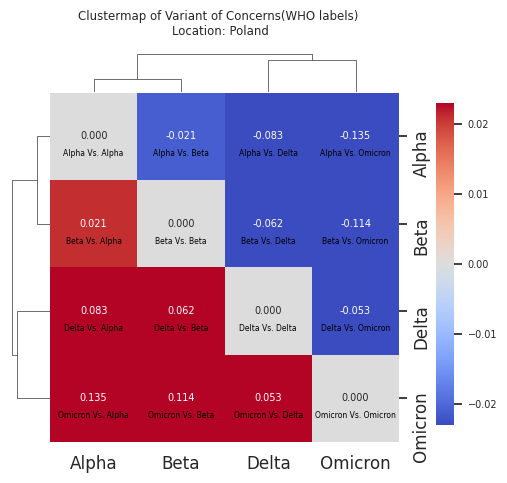

In [304]:
alpha_beta_po= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Poland_2021-01_2021-02_dist_mat.csv',
    index_col=0)
beta_delta_po = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Poland_2021-06_2021-07_dist_mat.csv',
    index_col= 0)
delta_omicron_po = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Poland_2021-12_2022-01_dist_mat.csv',
    index_col=0)

clustermap_obj_po = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_po,
                                                    beta_delta_po,
                                                    delta_omicron_po,
                                                    'Poland')
combined_distance_matrix_po = pd.DataFrame(clustermap_obj_po.data)



## South Korea

In [305]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'South Korea'])

In [306]:
 # #automation function finds the diatance matrix
automation_mine('South Korea', df_weekly_sum, start = '2020-12', end = '2021-02', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('South Korea', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('South Korea', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at South Korea : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01', '2021-02']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.014668
Beta   0.014668  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/South Korea_2020-12_2021-02_dist_mat.csv
Vaiants available at South Korea : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.039712
Delta  0.039712  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/South Korea_2021-05_2021-06_dist_mat.csv
Vaiants available at South Korea : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.047003
Omicron  0.047003  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/South Korea_2

Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.014668  0.054380  0.080371
Beta     0.014668  0.000000  0.039712  0.065703
Delta    0.054380  0.039712  0.000000  0.025991
Omicron  0.080371  0.065703  0.025991  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/South Korea_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.014668 -0.054380 -0.080371
Beta     0.014668  0.000000 -0.039712 -0.065703
Delta    0.054380  0.039712  0.000000 -0.025991
Omicron  0.080371  0.065703  0.025991  0.000000


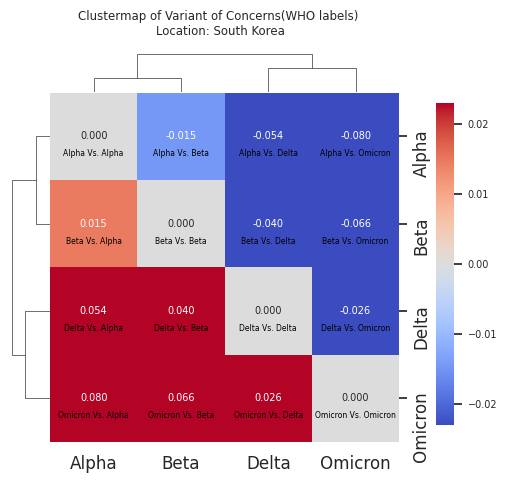

In [307]:
alpha_beta_sk= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/South Korea_2020-12_2021-02_dist_mat.csv',
    index_col=0)
beta_delta_sk = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/South Korea_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_sk = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/South Korea_2021-12_2022-01_dist_mat.csv',
    index_col=0)

clustermap_obj_sk = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_sk,
                                                    beta_delta_sk,
                                                    delta_omicron_sk,
                                                    'South Korea')
combined_distance_matrix_sk = pd.DataFrame(clustermap_obj_sk.data)



## Spain 

In [308]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Spain'])

In [309]:
 # #automation function finds the diatance matrix
automation_mine('Spain', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Spain', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Spain', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Spain : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.073431
Beta   0.073431  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Spain_2020-12_2021-01_dist_mat.csv
Vaiants available at Spain : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.009653
Delta  0.009653  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Spain_2021-05_2021-06_dist_mat.csv
Vaiants available at Spain : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
            Delta  Omicron
Delta    0.00000  0.06781
Omicron  0.06781  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Spain_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.073431  0.083084  0.150894
Beta     0.073431  0.000000  0.009653  0.077463
Delta    0.083084  0.009653  0.000000  0.067810
Omicron  0.150894  0.077463  0.067810  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Spain_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.073431 -0.083084 -0.150894
Beta     0.073431  0.000000 -0.009653 -0.077463
Delta    0.083084  0.009653  0.000000 -0.067810
Omicron  0.150894  0.077463  0.067810  0.000000


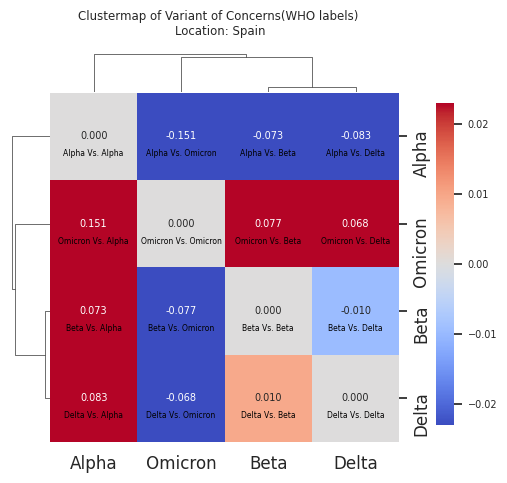

In [310]:
alpha_beta_sp= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Spain_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_sp = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Spain_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_sp = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Spain_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_sp = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_sp,
                                                    beta_delta_sp,
                                                    delta_omicron_sp,
                                                    'Spain')
combined_distance_matrix_sp = pd.DataFrame(clustermap_obj_sp.data)



## Switzerland

In [311]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Switzerland'])

In [312]:
 # #automation function finds the diatance matrix
automation_mine('Switzerland', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Switzerland', df_weekly_sum, start = '2021-06', end = '2021-07', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Switzerland', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Switzerland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.009731
Beta   0.009731  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Switzerland_2020-12_2021-01_dist_mat.csv
Vaiants available at Switzerland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-06', '2021-07']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.024382
Delta  0.024382  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Switzerland_2021-06_2021-07_dist_mat.csv
Vaiants available at Switzerland : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.071369
Omicron  0.071369  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Switzerland_2021-11_2021

Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.009731  0.034113  0.105482
Beta     0.009731  0.000000  0.024382  0.095751
Delta    0.034113  0.024382  0.000000  0.071369
Omicron  0.105482  0.095751  0.071369  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Switzerland_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.009731 -0.034113 -0.105482
Beta     0.009731  0.000000 -0.024382 -0.095751
Delta    0.034113  0.024382  0.000000 -0.071369
Omicron  0.105482  0.095751  0.071369  0.000000


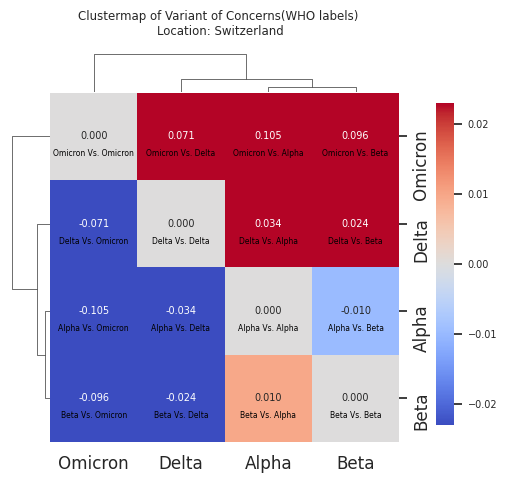

In [313]:
alpha_beta_sw= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Switzerland_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_sw = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Switzerland_2021-06_2021-07_dist_mat.csv',
    index_col= 0)
delta_omicron_sw = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Switzerland_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_sw = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_sw,
                                                    beta_delta_sw,
                                                    delta_omicron_sw,
                                                    'Switzerland')
combined_distance_matrix_sw = pd.DataFrame(clustermap_obj_sw.data)



## Turkey

In [314]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Turkey'])

In [315]:
 # #automation function finds the diatance matrix
automation_mine('Turkey', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Turkey', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Turkey', df_weekly_sum, start = '2021-12', end = '2022-01', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Turkey : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.097631
Beta   0.097631  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Turkey_2020-12_2021-01_dist_mat.csv
Vaiants available at Turkey : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
           Beta    Delta
Beta   0.00000  0.04985
Delta  0.04985  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Turkey_2021-05_2021-06_dist_mat.csv
Vaiants available at Turkey : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-12', '2022-01']
Diatance matrix: 
            Delta  Omicron
Delta    0.00000  0.05339
Omicron  0.05339  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Turkey_2021-12_2022-01_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.097631  0.147481  0.200871
Beta     0.097631  0.000000  0.049850  0.103240
Delta    0.147481  0.049850  0.000000  0.053390
Omicron  0.200871  0.103240  0.053390  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Turkey_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.097631 -0.147481 -0.200871
Beta     0.097631  0.000000 -0.049850 -0.103240
Delta    0.147481  0.049850  0.000000 -0.053390
Omicron  0.200871  0.103240  0.053390  0.000000


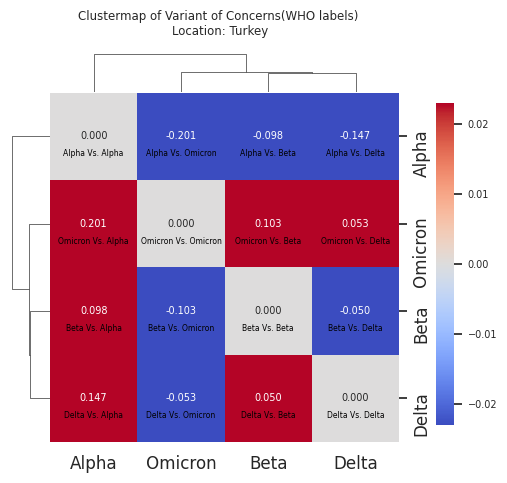

In [316]:
alpha_beta_tr= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Turkey_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_tr = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Turkey_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_tr = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Turkey_2021-12_2022-01_dist_mat.csv',
    index_col=0)

clustermap_obj_tr = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_tr,
                                                    beta_delta_tr,
                                                    delta_omicron_tr,
                                                    'Turkey')
combined_distance_matrix_tr = pd.DataFrame(clustermap_obj_tr.data)



## USA

In [317]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'USA'])

In [318]:
 # #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2021-03', end = '2021-04', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at USA : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.002825
Beta   0.002825  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2020-12_2021-01_dist_mat.csv
Vaiants available at USA : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-03', '2021-04']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.021935
Delta  0.021935  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-03_2021-04_dist_mat.csv
Vaiants available at USA : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.084864
Omicron  0.084864  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.002825  0.024760  0.109624
Beta     0.002825  0.000000  0.021935  0.106799
Delta    0.024760  0.021935  0.000000  0.084864
Omicron  0.109624  0.106799  0.084864  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.002825 -0.024760 -0.109624
Beta     0.002825  0.000000 -0.021935 -0.106799
Delta    0.024760  0.021935  0.000000 -0.084864
Omicron  0.109624  0.106799  0.084864  0.000000


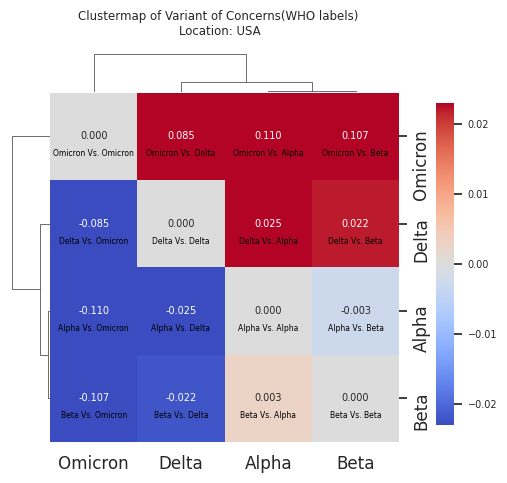

In [319]:
alpha_beta_us= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2020-12_2021-01_dist_mat.csv',
    index_col=0)
beta_delta_us = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-03_2021-04_dist_mat.csv',
    index_col= 0)
delta_omicron_us = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_us = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_us,
                                                    beta_delta_us,
                                                    delta_omicron_us,
                                                    'USA')
combined_distance_matrix_us = pd.DataFrame(clustermap_obj_us.data)



## Mexico

In [320]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Mexico'])

In [321]:
 # #automation function finds the diatance matrix
automation_mine('Mexico', df_weekly_sum, start = '2021-03', end = '2021-04', variant_choice_set= {'Alpha', 'Beta'})
# #automation function finds the diatance matrix
automation_mine('Mexico', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})
# #automation function finds the diatance matrix
automation_mine('Mexico', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Mexico : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-03', '2021-04']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.016381
Beta   0.016381  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Mexico_2021-03_2021-04_dist_mat.csv
Vaiants available at Mexico : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.024623
Delta  0.024623  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Mexico_2021-05_2021-06_dist_mat.csv
Vaiants available at Mexico : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.070888
Omicron  0.070888  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Mexico_2021-11_2021-12_dist_mat.csv


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.016381  0.041005  0.111893
Beta     0.016381  0.000000  0.024623  0.095511
Delta    0.041005  0.024623  0.000000  0.070888
Omicron  0.111893  0.095511  0.070888  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Mexico_continent_combined_distance_matrix_for_who_labels.csv
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.016381 -0.041005 -0.111893
Beta     0.016381  0.000000 -0.024623 -0.095511
Delta    0.041005  0.024623  0.000000 -0.070888
Omicron  0.111893  0.095511  0.070888  0.000000


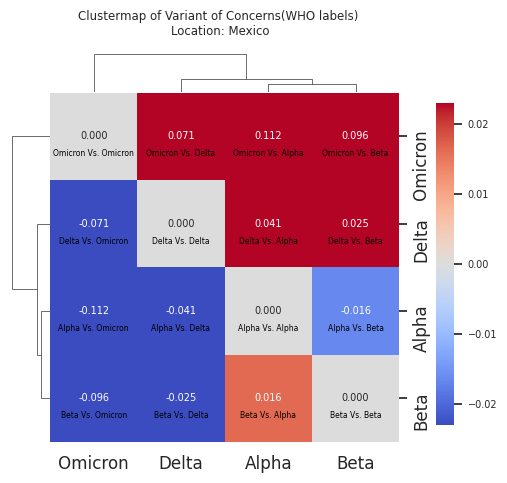

In [322]:
alpha_beta_mx= pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Mexico_2021-03_2021-04_dist_mat.csv',
    index_col=0)
beta_delta_mx = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Mexico_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
delta_omicron_mx = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Mexico_2021-11_2021-12_dist_mat.csv',
    index_col=0)

clustermap_obj_mx = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_mx,
                                                    beta_delta_mx,
                                                    delta_omicron_mx,
                                                    'Mexico')
combined_distance_matrix_mx = pd.DataFrame(clustermap_obj_mx.data)

